In [1]:
from differences import ATTgt, TWFE
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot, save_figure_and_close
import pandas as pd
import os



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)



In [2]:

df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                             Change in Crime Incidents, April 2019-March 2020   
                                                 \emph{Independent Variable}                                                                    
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m                                      1.525582e-33   
                                                 pre_treatment_change_in_group_0_crimes_500m                                    7.504883e-162   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                              7.280051e-01   
                                                 job_density_2013                                                                1.514046e-14   
                                                 med_hhinc2016                                                                   4.354695e-03   
                                                 poor_share2010                                                                  8.784612e-07   
                                                 popdensity2010                                                                  4.077500e-14   
Panel C: Case Initiation                         for_cause                                                                       1.406143e-01   
                                                 no_cause                                                                        9.331417e-01   
                                                 non_payment                                                                     1.657009e-02   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                                        5.452230e-01   
                                                 hasAttyP                                                                        2.909505e-01   
                                                 isEntityD                                                                       1.215549e-01   
                                                 isEntityP                                                                       4.407164e-03   

                                                                                                               
                                                                                             Treated Property  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m      4.209931e-01  
                                                 pre_treatment_change_in_group_0_crimes_500m     5.025774e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                              8.133641e-01  
                                                 job_density_2013                                5.501121e-01  
                                                 med_hhinc2016                                   1.427126e-02  
                                                 poor_share2010                                  4.904136e-03  
                                                 popdensity2010                                  6.737331e-01  
Panel C: Case Initiation                         for_cause                                       5.801068e-03  
                                                 no_cause                                        3.431724e-02  
                                                 non_payment                                     3.013004e-07  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                        2.406617e-08  
                                                 hasAttyP                                

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1151.910995   
        Change in Crime Incidents, 2017-2019            -155.352880   
Panel B Job density, 2013                              16161.032515   
        Median household income, 2016                  47553.063874   
        Poverty rate, 2010                                 0.279638   
        Population density, 2010                       23320.185868   
Panel C Filing for nonpayment                              0.716230   
Panel D Plaintiff is entity                                0.808377   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                    -28.225245   
        Change in Crime Incidents, 2017-2019                            -7.167593   
Panel B Job density, 2013                                            -1272.661768   
        Median household income, 2016                                 2997.870414   
        Poverty rate, 2010                                              -0.021030   
        Population density, 2010                                      -297.766413   
Panel C Filing for nonpayment                                           -0.106658   
Panel D Plaintiff is entity                                             -0.077182   

                                                                         \
                                                  \emph{p}     Weighted   
Panel A Total Crime Incidents, 2017           4.209931e-01   -33.861384   
        Change in Crime Incidents, 2017-2019  5.025774e-01     3.672512   
Panel B Job density, 2013                     5.501121e-01  -546.500941   
        Median household income, 2016         1.427126e-02 -1058.641495   
        Poverty rate, 2010                    4.904136e-03    -0.009375   
        Population density, 2010              6.737331e-01  -663.218568   
Panel C Filing for nonpayment                 3.013004e-07    -0.028315   
Panel D Plaintiff is entity                   1.569652e-05    -0.028438   

                                                        
                                              \emph{p}  
Panel A Total Crime Incidents, 2017           0.339369  
        Change in Crime Incidents, 2017-2019  0.730163  
Panel B Job density, 2013                     0.799256  
        Median household income, 2016         0.302261  
        Poverty rate, 2010                    0.198113  
        Population density, 2010              0.351755  
Panel C Filing for nonpayment                 0.080822  
Panel D Plaintiff is entity                   0.075707

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:09<00:00, 115.90it/s]


-3.8572092956902573
-2.4519351755424625
-2.377799053239512
-0.47381200336676355


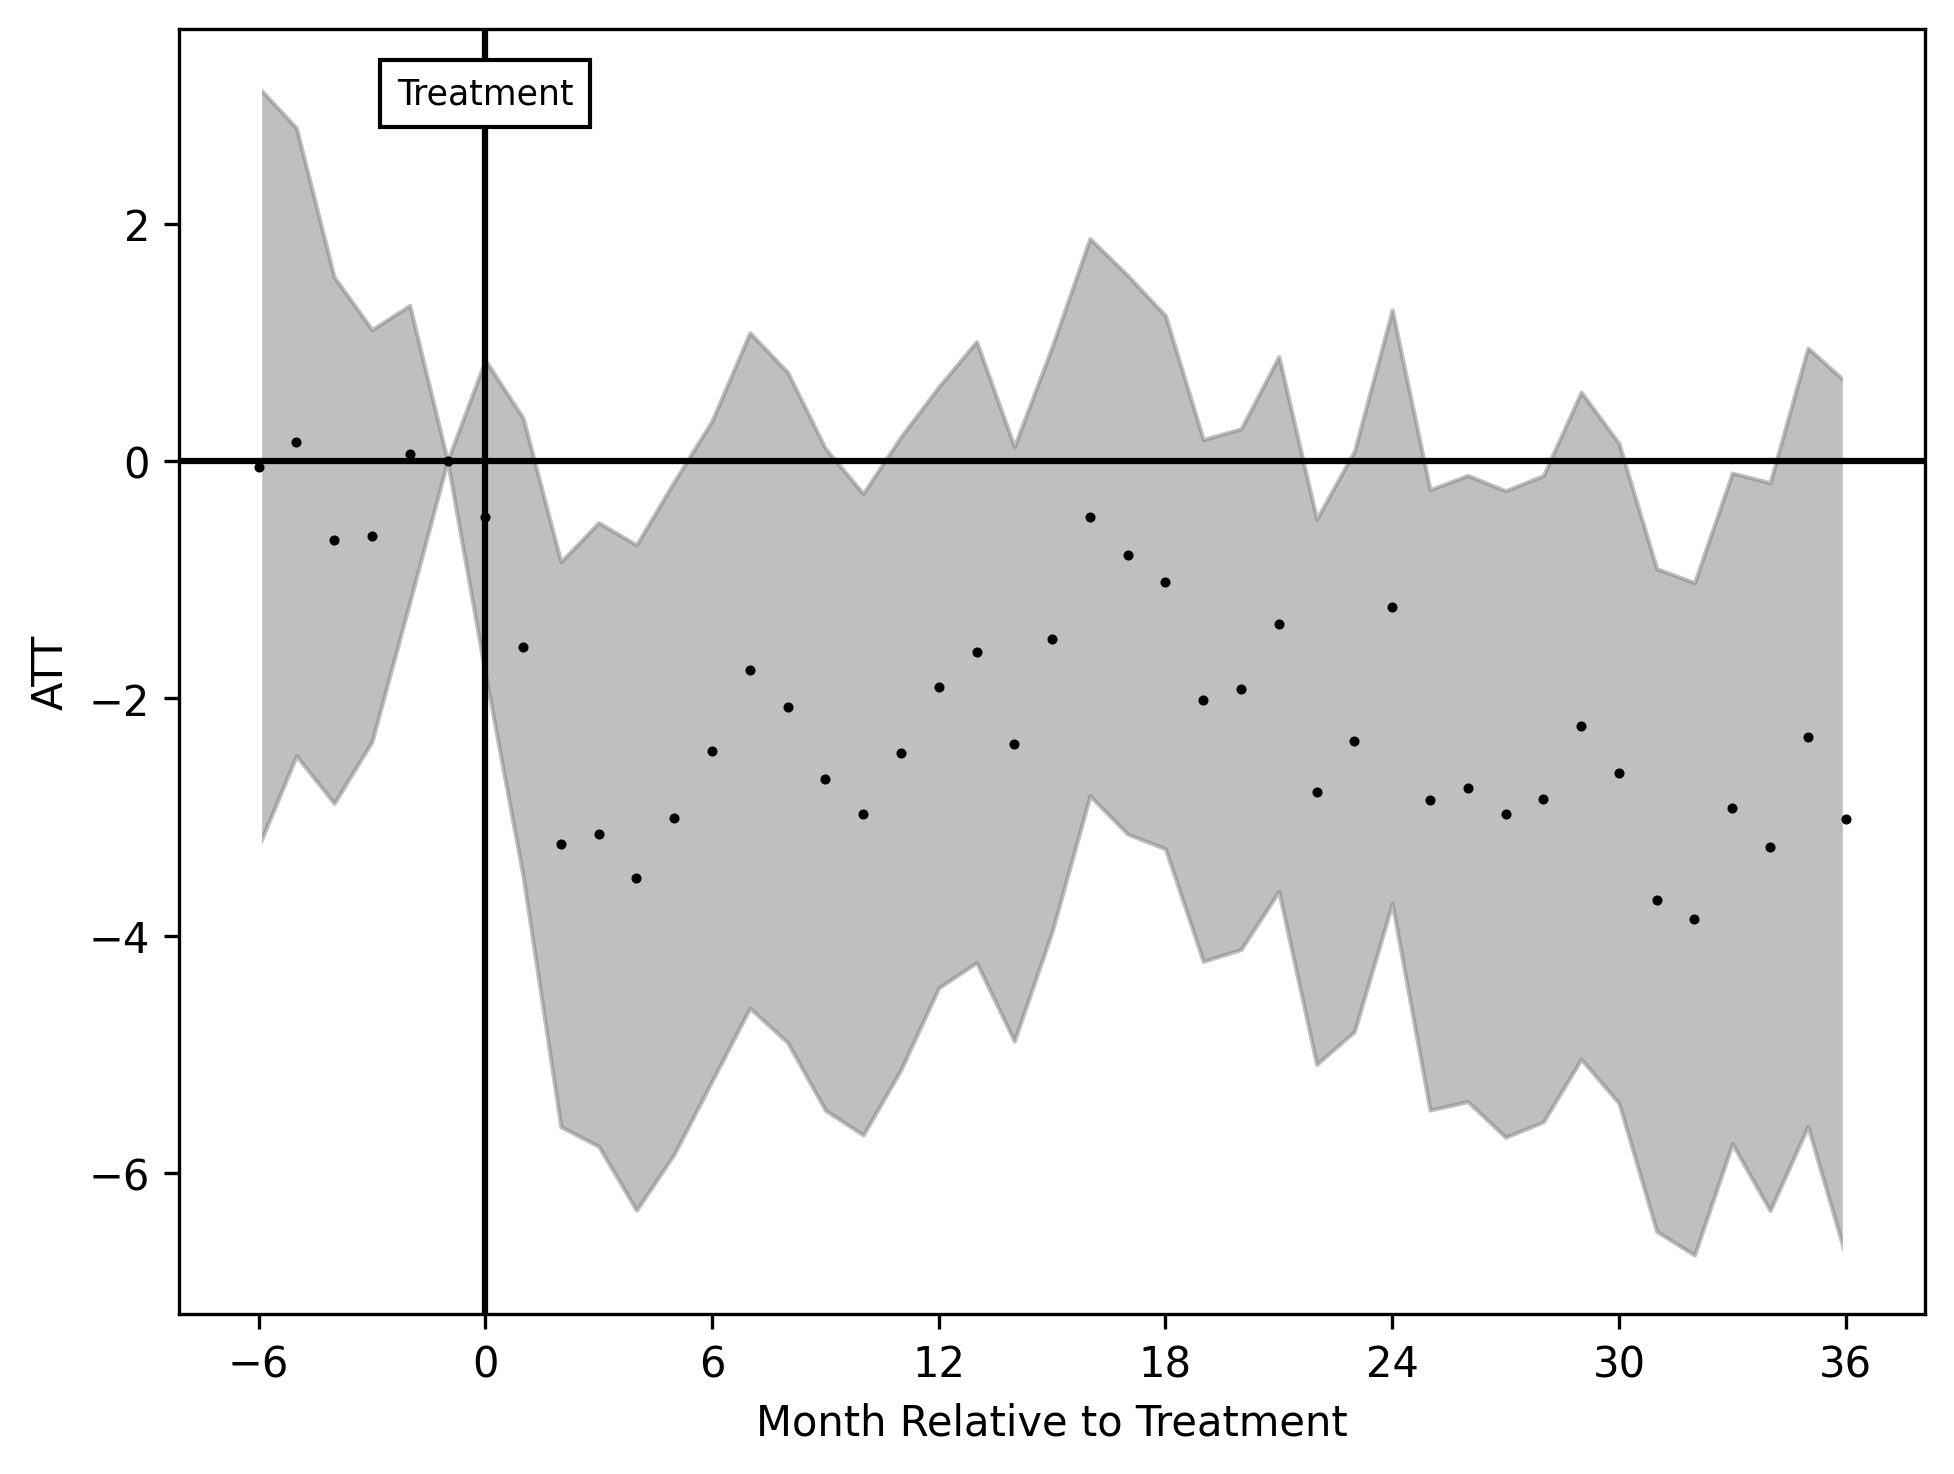

In [9]:
# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')
aggregate_by_event_time_and_plot(att_gt, start_period=-6,
                                 end_period=36,
                                 title="",ax=ax)
plt.show()
save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES,   "att_gt_unconditional_event_study_long_horizon.png"))


In [10]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:15<00:00, 69.85it/s] 


-4.749507761693165
-3.2525044704518584
-3.247140545166369
-1.4295569668506536


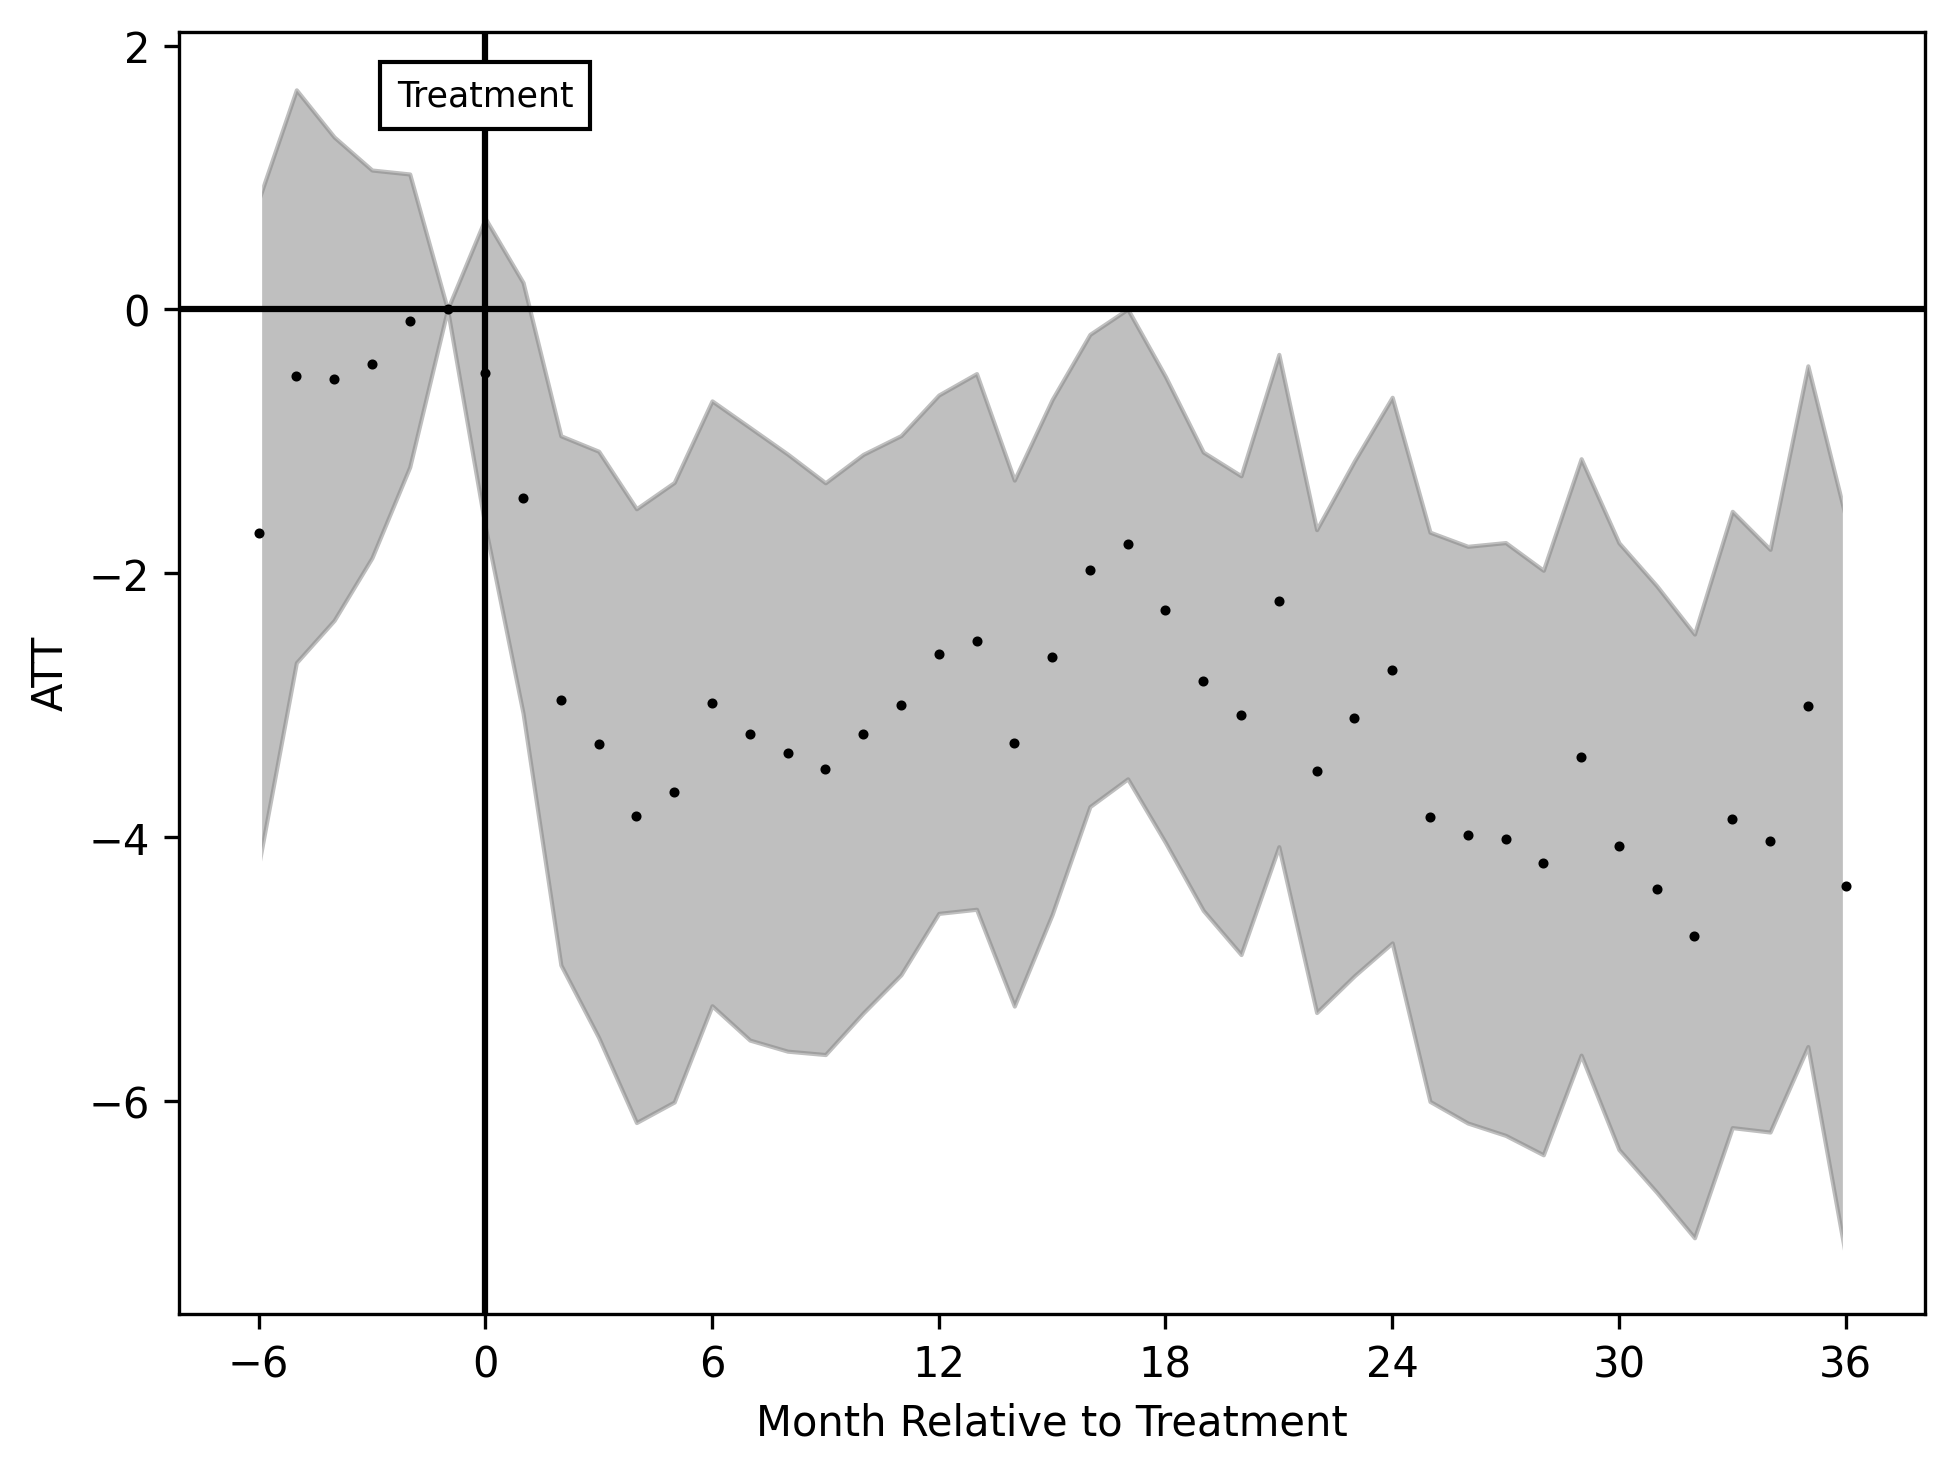

In [12]:

# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')
aggregate_by_event_time_and_plot(att_gt, start_period=-6,
                                 end_period=36,
                                 title="", ax=ax)
plt.show()
save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES,  "att_gt_dr_event_study_long_horizon2.png"))
